In [1]:
%load_ext autoreload
%autoreload 2
!hostname
!pwd
import os, sys
print(sys.executable)
os.environ['CUDA_VISIBLE_DEVICES'] = "4"

fish-gcp005
/home/akarshkumar0101/nca-alife/src
/home/akarshkumar0101/.virtualenvs/nca-alife-torch/bin/python3


In [2]:
import os, sys, glob, pickle
from functools import partial

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_theme()

from tqdm.auto import tqdm
from einops import rearrange, reduce, repeat

In [3]:
import torch
import torch.nn as nn

In [12]:
from PIL import Image
import requests
from transformers import AutoProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

inputs = processor(
    text=["a photo of a cat", "a photo of a dog"], images=image, return_tensors="pt", padding=True
)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities

/home/akarshkumar0101/.virtualenvs/nca-alife-torch/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [15]:
model = model.to('cuda')

In [16]:
x = inputs['pixel_values'].to('cuda')

In [27]:
for i in tqdm(range(1000)):
    x = torch.randn(32, 3, 224, 224, device='cuda')
    with torch.no_grad():
        model.vision_model(x)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [47]:
for i in tqdm(range(1000)):
    x = torch.randn(32, 3, 224, 224, device='cuda')
    y = model.get_image_features(x)
    loss = y.mean()
    loss.backward()

  0%|          | 0/1000 [00:00<?, ?it/s]

In [170]:
from torchvision import transforms
trans_aug = transforms.Compose([
    transforms.ColorJitter(brightness=.5, contrast=0.5, saturation=0.5, hue=0.1),
    transforms.RandomResizedCrop(224, scale=(0.1, 1.)),
    transforms.RandomPerspective(distortion_scale=0.5, p=1., fill=0.),
])
def augment_img(x):
    xs = torch.cat([trans_aug(x) for i in range(16)])
    return xs

In [171]:
img = torch.tensor(np.array(image.resize((224, 224))))/255.
img = rearrange(img, 'h w d -> 1 d h w')
img = augment_img(img)

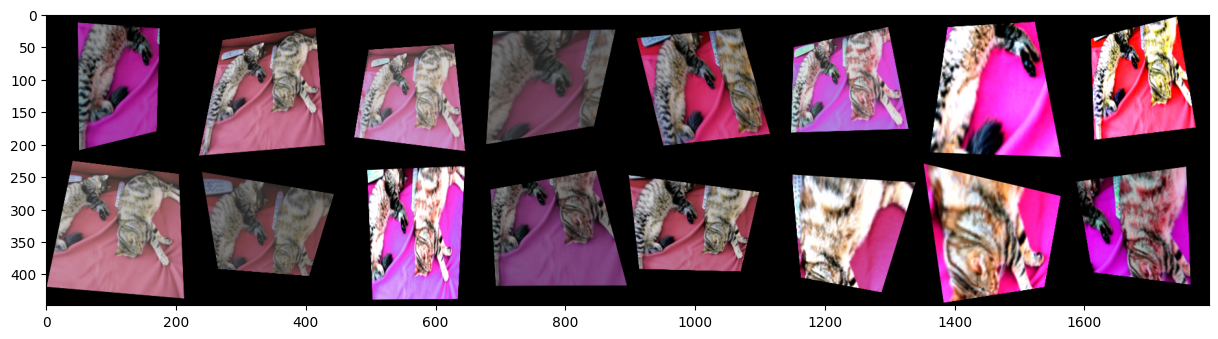

In [172]:
plt.figure(figsize=(15, 4))
plt.imshow(rearrange(img, '(r c) d h w -> (r h) (c w) d', r=2).numpy())
plt.show()